In [1]:
import sys

sys.path.append("../berries")


In [2]:
import random_utils
seed = 0
key_gen = random_utils.infinite_safe_keys(seed)

from datasets import load_dataset
cache_dir="$HOME/.cache/huggingface/datasets"
mnist = load_dataset("mnist", cache_dir=cache_dir, trust_remote_code=True).with_format("jax")
#mnist = load_dataset("fashion_mnist", cache_dir=cache_dir, trust_remote_code=True).with_format("jax")
mnistData = mnist['train']

X_img = mnistData['image']
y = mnistData['label']
X_img_test = mnist["test"]["image"]
n_test_samples = X_img_test.shape[0]
y_test = mnist["test"]["label"]
n_samples, _, _  = X_img.shape
X_train = X_img.reshape((n_samples, 1, 28, 28))
X_test = X_img_test.reshape((n_test_samples, 1, 28, 28))
n_channels = 1
d_x = (28, 28)
d_y = len(set(y.tolist()))

In [20]:
from jax.image import resize
from jax.numpy import int32, int64
from pf import F, _
from plot_utils import visualize_matrix
from IPython.display import display

q_x1 = 16
q_x2 = 16
n_x_q = 8

def quantize(x):
    x = (F(resize).vmap((0, None, None), 0)(x, (1, q_x1, q_x2), "bilinear") + n_x_q//2) // (256 // n_x_q) 
    return int32(x)

X_train_q = quantize(X_train)
X_test_q = quantize(X_test)
n_nodes_x = n_x_q*q_x1*q_x2
print(n_nodes_x)

2048


In [21]:
from jax import jit, vmap, numpy as np
from tqdm import tqdm
# Predefined shape of A1

idx_x1 = np.arange(q_x1)
idx_x2 = np.arange(q_x2)
i, j, k, l = np.meshgrid(idx_x1, idx_x1, idx_x2, idx_x2, indexing='ij')
W = np.zeros((n_nodes_x, n_nodes_x))

def coords_to_index(x1, x2, v):
    index = ((x1 * q_x2) + x2) * n_x_q + v
    return index

def index_to_coords(index):
    x1 = index // (n_x_q * q_x2)
    remainder = index % (n_x_q * q_x2)
    x2 = remainder // n_x_q
    v = remainder % n_x_q
    return x1, x2, v

def update_W(W, x):
    index1 = coords_to_index(i, j, x[i, j]).ravel()
    index2 = coords_to_index(k, l, x[k, l]).ravel()
    W = W.at[index1, index2].add(1)
    return W

update_W_vectorized = vmap(update_W, in_axes=(None, 0))

print(W.sum())

batch_size = 32

def train_W(W, X):
    for i in range(0, n_samples, batch_size):
        batch = X[i:i + batch_size, :, :]
        W = jit(update_W_vectorized)(W, batch)
    return W

def train_W1(W, X):
    for i in tqdm(range(0, n_samples)):
        W = jit(update_W)(W, X[i, :, :])
    return W

W = train_W1(W, X_train_q)
print(W.sum())


/tmp/ipykernel_17698/3345982955.py:8: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  W = np.zeros((n_nodes_x, n_nodes_x), dtype=int64)


0


100%|██████████| 60000/60000 [00:27<00:00, 2178.23it/s]

-1509949440


In [36]:
import numpy as np

def create_B1_matrix(A1):
    m, n = A1.shape
    idx_m = np.arange(m)
    idx_n = np.arange(n)
    B1 = np.zeros((4 * m * n, 4 * m * n), dtype=int)

    i, j, k, l = np.meshgrid(idx_m, idx_n, idx_m, idx_n, indexing='ij')

    value1 = A1[i, j]
    value2 = A1[k, l]

    index1 = ((i * n + j) * 4 + value1).ravel()
    index2 = ((k * n + l) * 4 + value2).ravel()

    B1[index1, index2] = 1

    return B1

# Example usage
A1 = np.array([[1, 0, 2], [2, 3, 1]])
B1 = create_B1_matrix(A1)

# Print the resulting B1 matrix
print(B1)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 1

In [19]:
from jax.numpy import zeros
W = zeros((n_nodes, n_nodes))

def get_connection(x):
    

(2048, 2048)

x:
    pos:
        array shape: (256, 784)
    val:
        array shape: (256, 16)
    total params: 204800
y:
    array shape: (512, 10)
total params: 209920

accuracy: 0.12999999523162842
1.9986888


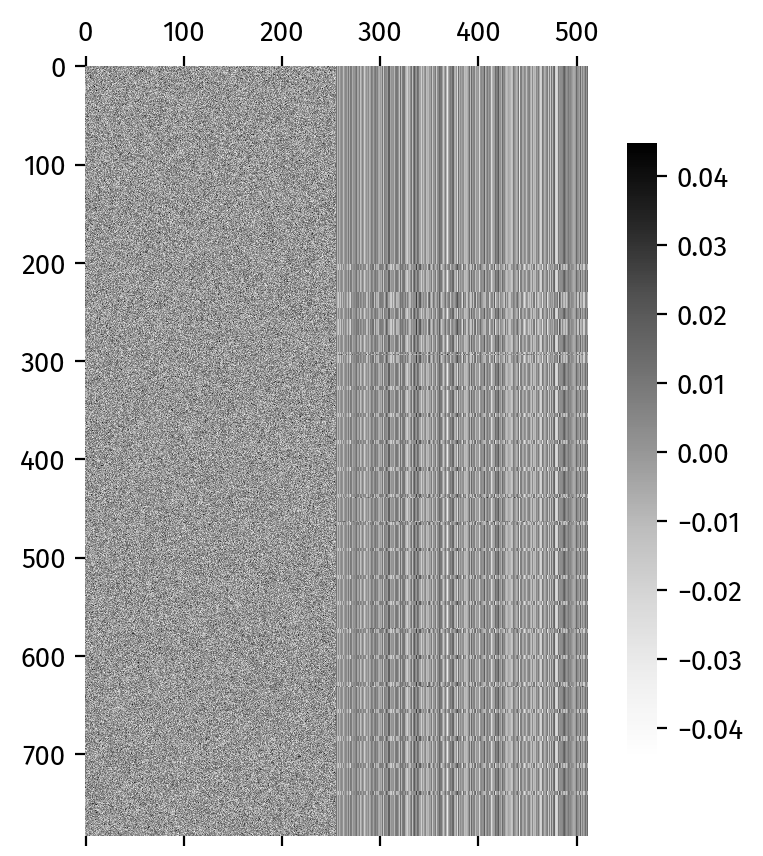

In [10]:
from jax.numpy.linalg import norm
from jax import grad, jit
import nn
import importlib
importlib.reload(nn)
import pf
importlib.reload(pf)
from nn import init_weights, fmt_weights
import optax

pos_dim = 0


def input_encode(W, x, x_pos):
    h_pos = W['pos'][:, x_pos]
    h_val = W['val'][:, x]
    h = r_[h_pos, h_val]
    # return W['proj'] @ h
    return h



def input_encode_config(in_channels, init):
    return {
        'pos': {
            "size": ( d_channels//2, d_x[0] * d_x[1]),
            "init": init
        },
        'val': {
            "size": ( d_channels//2, n_x_q),
            "init": init
        },
        # 'proj': {
        #     "size": (d_channels, d_channels),
        #     "init": init
        # }
    }

def head(W, x, y):
    val_flat = x.reshape(-1)
    pos_x1 = arange(d_x[0] * d_x[1])
    h_x = F(input_encode).vmap((None, 0, 0), 0)(W['x'], val_flat, pos_x1)
    h_y = W['y'][:, y]
    return h_x, h_y[None, :]

def head_config(init):
    return {
        'x': input_encode_config(3, init),
        'y': {
            "size": (d_channels, d_y),
            "init": {"type": "normal", "std": 0.1}
        } 
    }



def loss_cos_classify_contrastive(Wy, h_x, h_y):
    X_norm = h_x / norm(h_x, axis=1, keepdims=True)
    y_norm = h_y / norm(h_y, axis=1, keepdims=True)
    X_sim = X_norm @ y_norm.T
    #X_sim_neg = X_norm @ Wy
    return 2 * mean(1 - X_sim)# - mean(1 - X_sim_neg)




def predict_cos(W, x):
    val_flat = x.reshape(-1)
    h_x = F(input_encode).vmap((None, 0, 0), 0)(W['x'], val_flat, arange(d_x[0] * d_x[1]))
    #h_X = mean(h_x, axis=pos_dim)[:, None]
    h_y_all = W['y']
    h_y_all_norm = h_y_all / norm(h_y_all, axis=0, keepdims=True)
    h_X_norm = h_x / norm(h_x, axis=0, keepdims=True)
    dist = mean(1 - h_y_all_norm.T @ h_X_norm.T, axis=-1)
    return dist.argmin()

    
predict = F(predict_cos)

@F
def loss1(W, X, y):
    h_x, h_y = head(W, X, y)
    return loss_cos_classify_contrastive(W['y'], h_x, h_y)

# method = {"type": "zer0", "std": 0.001}
method = {"type": "normal", "std": 0.01}
# method = {"type": "normal", "std": 0.1}

W = init_weights(next(key_gen), head_config(method))
print(fmt_weights(W)[0])
# mean_loss = F(full_loss_cos)



loss_batch = loss1.vmap((None, 0, 0), 0) >> mean

pred_batch = F(predict).vmap((None, 0), 0)

@jit
def accuracy(W, X, y):
    return mean(pred_batch(W, X) == y)

from plot_utils import visualize_matrix
from IPython.display import display

visualize_matrix(head(W, X_test[0, :], y_test[0])[0], dpi=200)

acc = accuracy(W, X_test[:100, :], y_test[:100])
print(f"accuracy: {acc}")


loss0 = loss_batch(W, X_test[:100, :], y_test[:100])
print(loss0)


In [11]:
import optax
from jax.tree_util import tree_map
import init_utils

import math, random
import jax.numpy as np



batch_size = 128

@jit
def get_accuracy_b_t(W):
    n, val = 0, 0
    for i in range(0, n_test_samples, batch_size):
        real_batch_size = min(n_test_samples - i, batch_size)
        acc_all = accuracy(W, X_test[i:i + batch_size, :], y_test[i:i + batch_size])
        val +=  mean(acc_all) * real_batch_size
        n += real_batch_size
    return val / n

@jit
def loss_b_dt(W):
    batch_size_use = batch_size // 4
    n, val = 0, 0
    for i in range(0, n_test_samples, batch_size_use):
        real_batch_size = min(n_test_samples - i, batch_size_use)
        val += mean(loss_batch(W, X_test[i:i + batch_size_use, :], y_test[i:i + batch_size_use])) * real_batch_size
        n += real_batch_size
    return val / n



def sample():
    index = random.sample(range(n_samples), batch_size)
    return X_train[index, :], y[array(index)]



lr = 0.0001
mask_fn = lambda p: tree_map(lambda x: not isinstance(x, int), p)
# opt = optax.multi_transform({"sgd": optax.rmsprop(lr), "zero": optax.set_to_zero()}, mask_fn)
opt = optax.masked(optax.adam(lr), mask_fn)
state = opt.init(W)
state_x = opt.init(W['x'])
state_y = opt.init(W['y'])

method = {"type": "zer0", "std": 0.001}
# method = {"type": "normal", "std": 0.01}
# method = {"type": "normal", "std": 0.1}

W0 = W = init_weights(next(key_gen), head_config(method))


@jit
def update(W, x, y, opt_state):
    grads = grad(loss_batch)(W, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_W = optax.apply_updates(W, updates)
    return new_W, opt_state

def loss_sep_x(Wx, Wy, x, y):
    return loss_batch({"x": Wx, "y": Wy}, x, y)

def loss_sep_y(Wy, Wx, x, y):
    return loss_batch({"x": Wx, "y": Wy}, x, y)

@jit
def update_x(W, x, y, opt_state):
    grads = grad(loss_sep_x)(W['x'], W['y'], x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_Wx = optax.apply_updates(W['x'], updates)
    return {'x': new_Wx, 'y': W['y']}, opt_state

@jit
def update_y(W, x, y, opt_state):
    grads = grad(loss_sep_y)(W['y'], W['x'], x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_Wy = optax.apply_updates(W['y'], updates)
    return {'x': W['x'], 'y': new_Wy}, opt_state

In [12]:
from collections import Counter
for i in range(50000):
    xx, yy = sample()
    # W, state = update(W, xx, yy, state)
    W, state_x = update_x(W, xx, yy, state_x)
    # W, state_y = update_y(W, xx, yy, state_y)
    if i < 10 or i % 200 == 0:
        out = jit(pred_batch)(W, xx)
        print(f"---Iter {i}---")
        print(Counter(out.tolist()))
        print(mean(accuracy(W, xx, yy)))
        print(get_accuracy_b_t(W))
        print(loss_b_dt(W))


print(loss_b_dt(W))


---Iter 0---
Counter({1: 120, 2: 8})
0.046875
0.0506
1.9952027
---Iter 1---
Counter({1: 121, 2: 7})
0.046875
0.0513
1.9941767
---Iter 2---
Counter({1: 123, 2: 5})
0.0546875
0.0557
1.9931495
---Iter 3---
Counter({1: 119, 2: 9})
0.0546875
0.0572
1.9921255
---Iter 4---
Counter({1: 122, 2: 6})
0.0703125
0.0589
1.9911005
---Iter 5---
Counter({1: 116, 2: 12})
0.03125
0.0594
1.9900765
---Iter 6---
Counter({1: 123, 2: 5})
0.078125
0.062099997
1.9890519
---Iter 7---
Counter({1: 122, 2: 6})
0.0546875
0.066199996
1.9880406
---Iter 8---
Counter({1: 118, 2: 10})
0.078125
0.073699996
1.9870324
---Iter 9---
Counter({1: 123, 2: 5})
0.1015625
0.0814
1.9860287
---Iter 200---
Counter({5: 124, 3: 4})
0.109375
0.091
1.8034189
---Iter 400---
Counter({5: 127, 3: 1})
0.1171875
0.088999994
1.6501628
---Iter 600---
Counter({3: 87, 5: 41})
0.1171875
0.102699995
1.5415512
---Iter 800---
Counter({0: 128})
0.09375
0.098
1.472815
---Iter 1000---
Counter({0: 128})
0.0859375
0.098
1.4334375
---Iter 1200---
Counter({0:

In [13]:
W0 = W

In [106]:
from sklearn.manifold import TSNE

from jax.numpy import vstack
import matplotlib.pyplot as plt

yd = W['y']
hx0, y0 = head(W, X_test[0, :], y_test[0])
hx1, y1 = head(W, X_test[1, :], y_test[1])
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(vstack([hx0, hx1, yd.T]))

# X_embedded = TSNE(n_components=2, learning_rate='auto',
#                     init='random', perplexity=3).fit_transform(vstack([yd.T, mixer_head(W, xx[0, :], yy[0]), mixer_head(W, xx[1, :], yy[1])]))

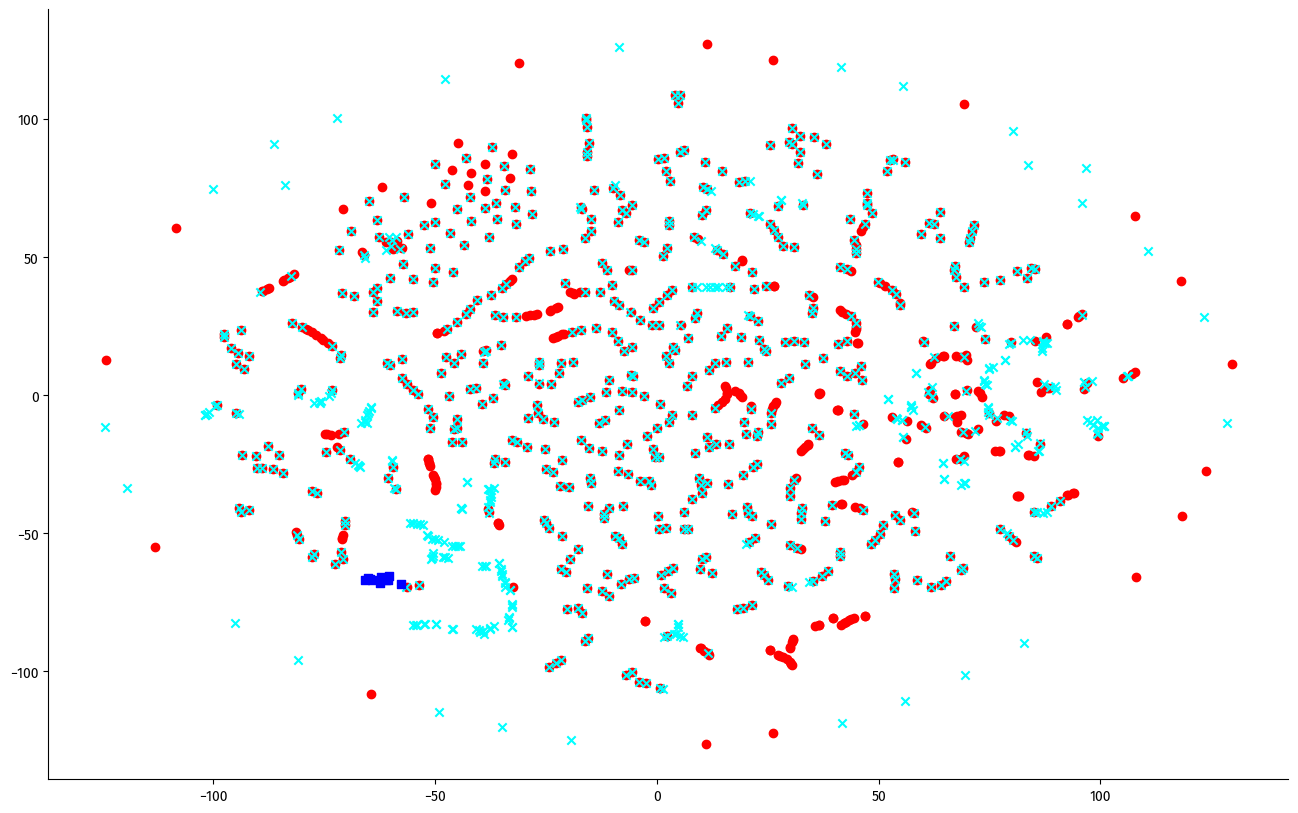

(1578, 2)


In [107]:

plt.figure(figsize=(16,10))
plt.scatter(X_embedded[:784, 0], X_embedded[:784, 1], c='r')
# plt.scatter(X_embedded[785:2*784+1, 0], X_embedded[785: 2*784+1, 1], c='pink')
#plt.scatter(X_embedded[2*784+1: -10, 0], X_embedded[ 2*784+1: -10, 1], c='blue')
plt.scatter(X_embedded[785: -10, 0], X_embedded[785: -10, 1], c='cyan', marker='x')
plt.scatter(X_embedded[-10:, 0], X_embedded[-10:, 1], c='blue', marker='s')
plt.show()
print(X_embedded.shape)

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x78e61c0dea70>)

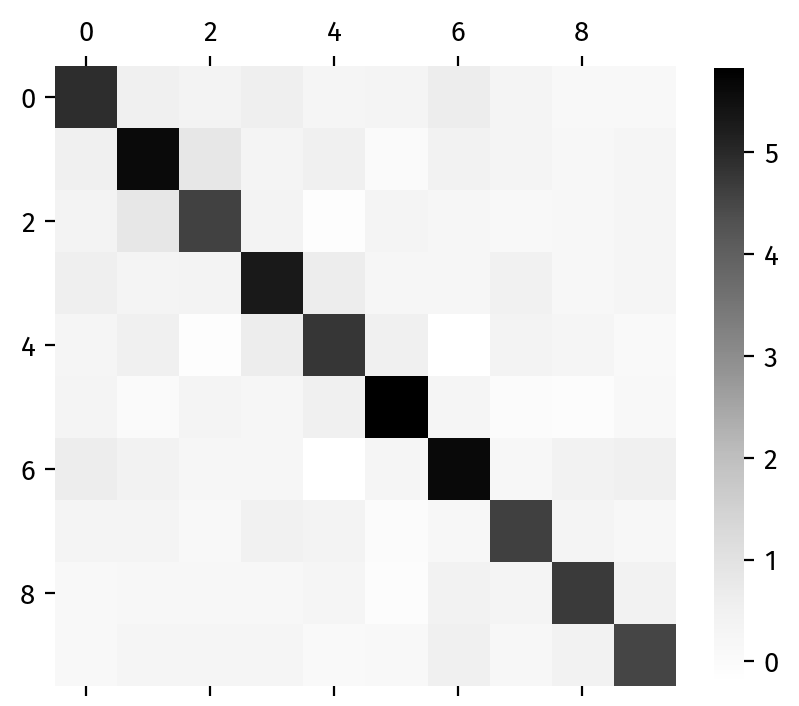

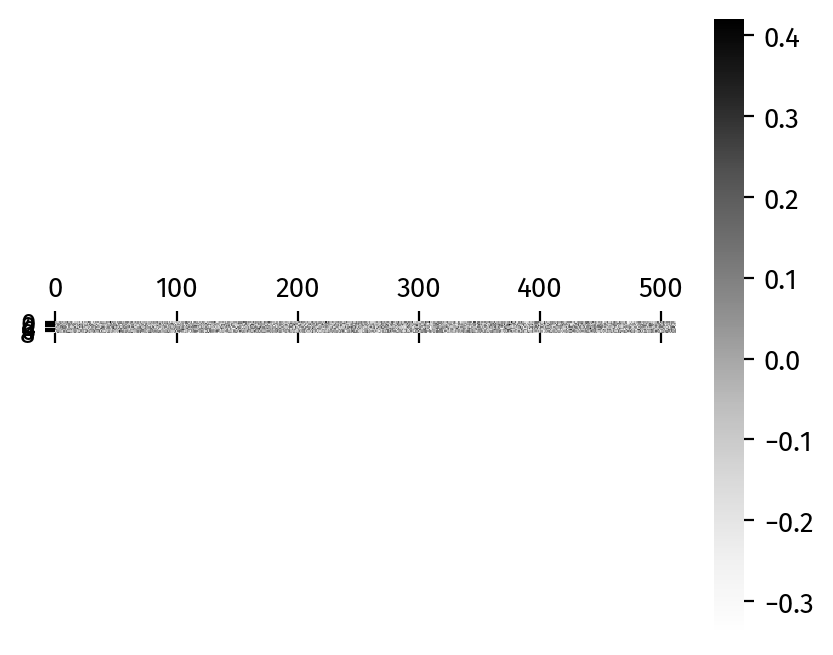

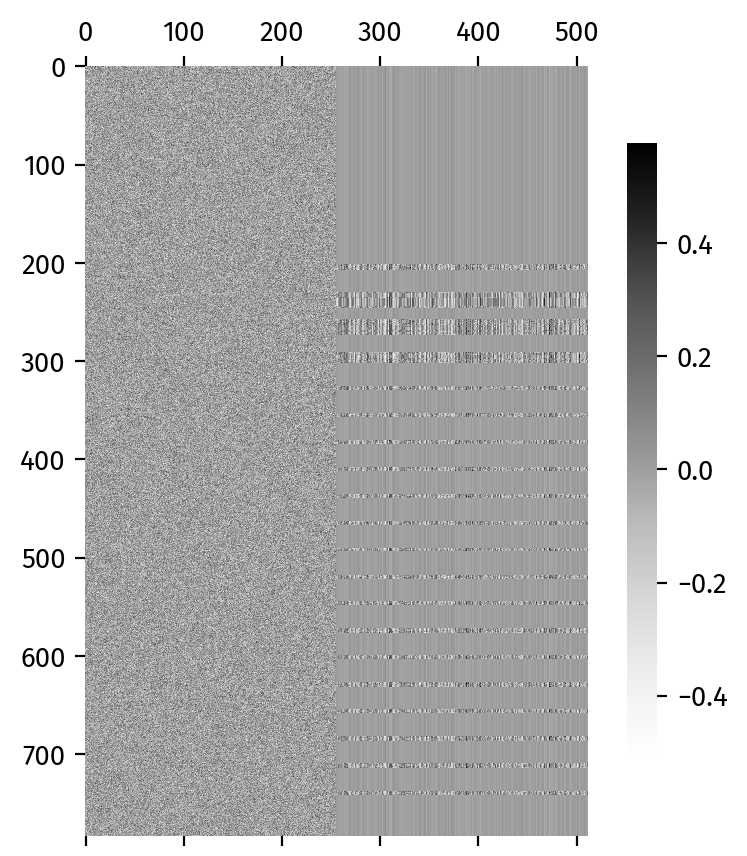

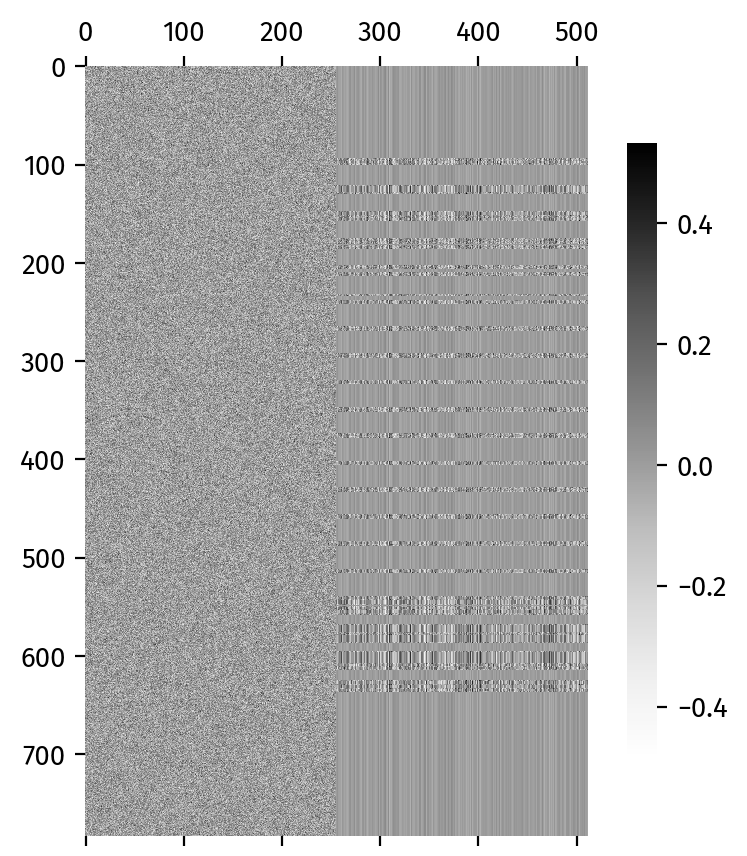

In [99]:
visualize_matrix(yd.T @ yd, dpi=200)
visualize_matrix(yd.T, dpi=200)
visualize_matrix(hx0 - mean(hx0, axis=0), dpi=200)
visualize_matrix(hx1 - mean(hx1, axis=0), dpi=200)